In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kruskal, f_oneway, chi2_contingency
from sklearn.preprocessing import LabelEncoder
import shap


In [90]:

df = pd.read_csv('train.csv')


X = df.drop('price_range', axis=1)
y = df['price_range']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


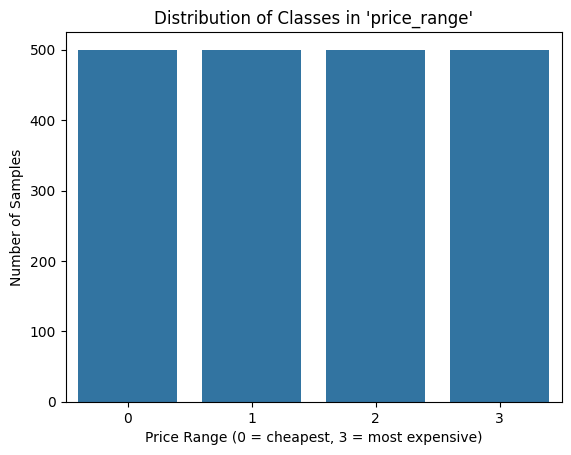

price_range
1    0.25
2    0.25
3    0.25
0    0.25
Name: Proportion, dtype: float64


In [91]:
sns.countplot(x=y)
plt.title("Distribution of Classes in 'price_range'")
plt.xlabel("Price Range (0 = cheapest, 3 = most expensive)")
plt.ylabel("Number of Samples")
plt.show()


print(y.value_counts(normalize=True).rename("Proportion"))

In [92]:

stat_results = []

# Loop for each column
for col in X.columns:
    feature_type = "binary" if X[col].nunique() == 2 else "numerical"
    
    if feature_type == "numerical":
        # Split the variable by price group
        groups = [X[col][y == i] for i in sorted(y.unique())]

        # Normality test (Shapiro-Wilk) in each group
        normal = all([shapiro(group.sample(n=min(30, len(group)), random_state=42))[1] > 0.05 for group in groups])

        # Choose test
        if normal:
            stat, p = f_oneway(*groups)
            test_name = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_name = "Kruskal-Wallis"

    else:  # Binary
        # Build a contingency table
        contingency = pd.crosstab(X[col], y)
        stat, p, _, _ = chi2_contingency(contingency)
        test_name = "Chi-Square"

    stat_results.append({
        'Feature': col,
        'Type': feature_type,
        'Test': test_name,
        'P-Value': p,
        'Significant (< 0.05)': p < 0.05
    })

# Show results in ascending order of p-value
results_df = pd.DataFrame(stat_results).sort_values(by='P-Value')
print(results_df)
results_df.to_excel("hypothesis_testing_results.xlsx", index=False)

          Feature       Type            Test       P-Value  \
13            ram  numerical  Kruskal-Wallis  0.000000e+00   
0   battery_power  numerical  Kruskal-Wallis  2.048329e-19   
12       px_width  numerical  Kruskal-Wallis  4.477100e-14   
11      px_height  numerical           ANOVA  1.886085e-12   
8       mobile_wt  numerical  Kruskal-Wallis  1.274450e-02   
6      int_memory  numerical           ANOVA  3.277694e-02   
9         n_cores  numerical  Kruskal-Wallis  4.859243e-02   
14           sc_h  numerical  Kruskal-Wallis  8.253456e-02   
16      talk_time  numerical  Kruskal-Wallis  1.796384e-01   
7           m_dep  numerical  Kruskal-Wallis  2.058665e-01   
18   touch_screen     binary      Chi-Square  2.747011e-01   
5          four_g     binary      Chi-Square  3.647141e-01   
15           sc_w  numerical  Kruskal-Wallis  4.510617e-01   
10             pc  numerical  Kruskal-Wallis  4.997808e-01   
4              fc  numerical  Kruskal-Wallis  5.564867e-01   
1       

In [93]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

c:\Users\lpraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


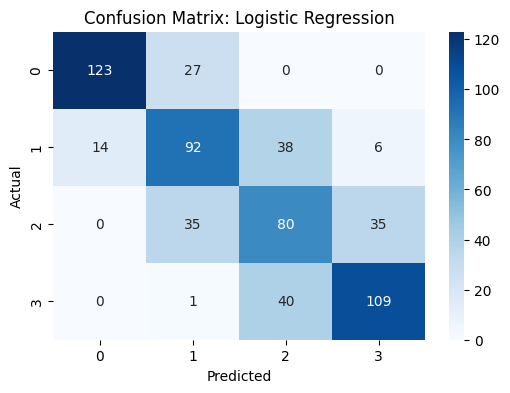

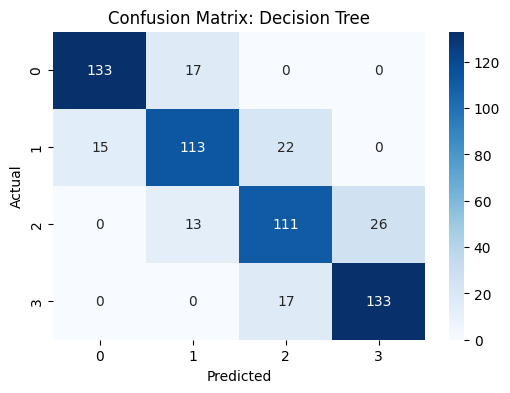

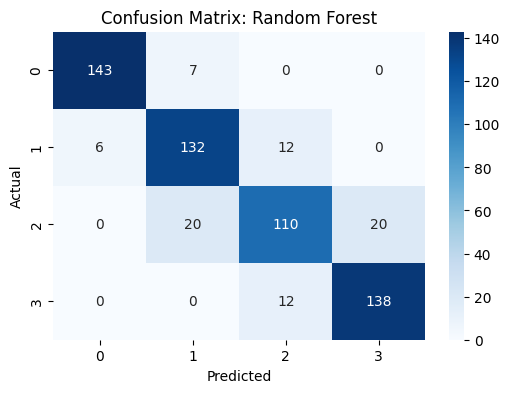

c:\Users\lpraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:01:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


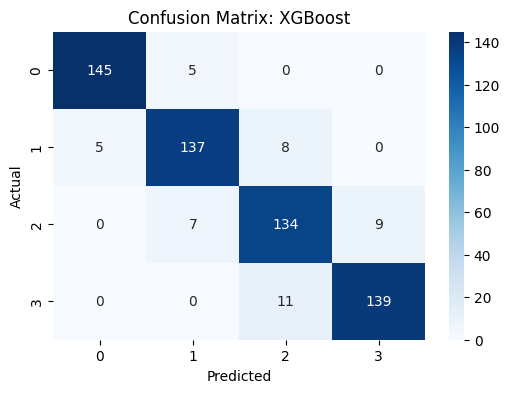

In [94]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [95]:
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
display(results_df.sort_values(by='F1-Score', ascending=False))

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score
3,XGBoost,0.925000,0.925284,0.925000,0.925107
2,Random Forest,0.871667,0.871058,0.871667,0.870411
1,Decision Tree,0.816667,0.816334,0.816667,0.816197
0,Logistic Regression,0.673333,0.681089,0.673333,0.676642


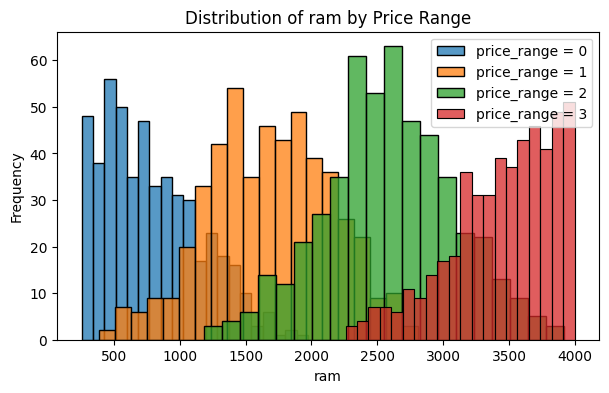

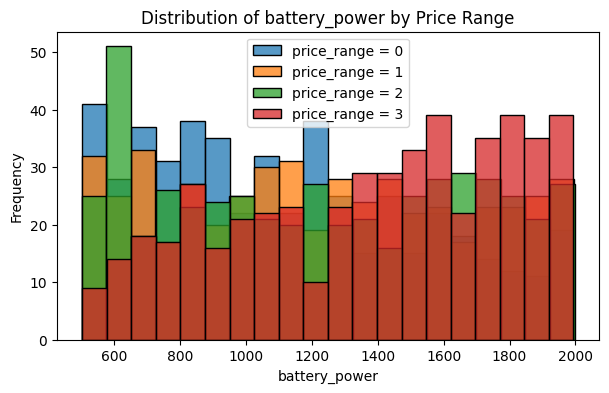

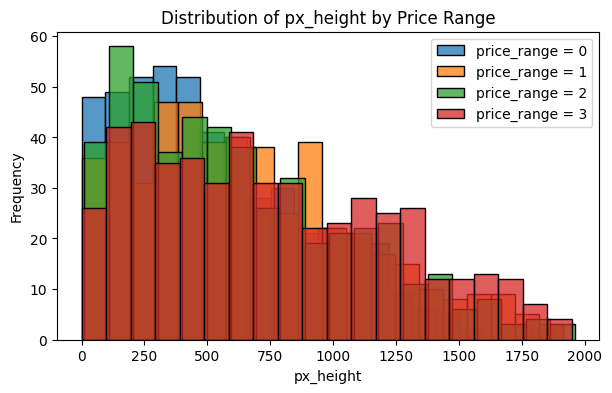

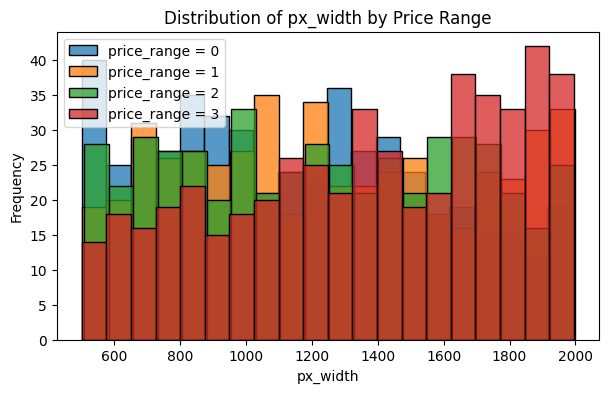

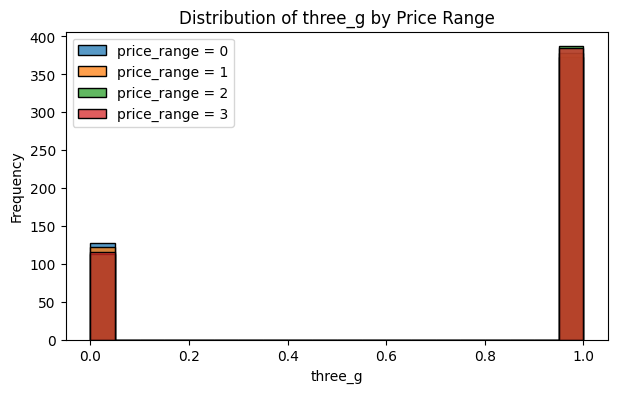

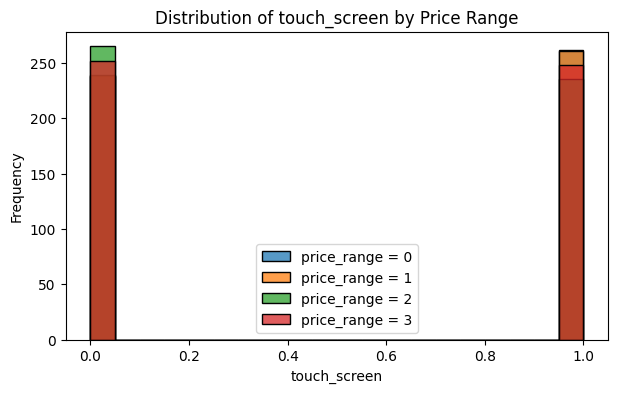

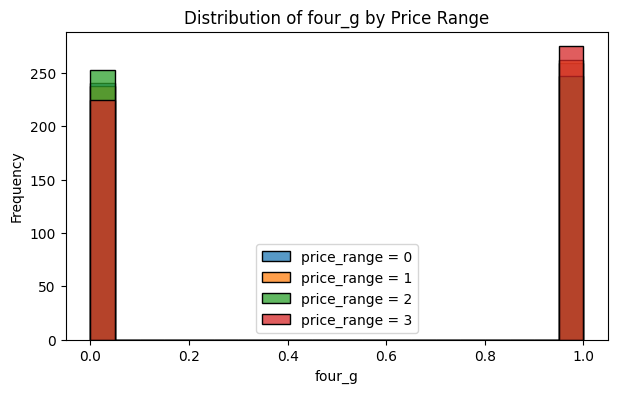

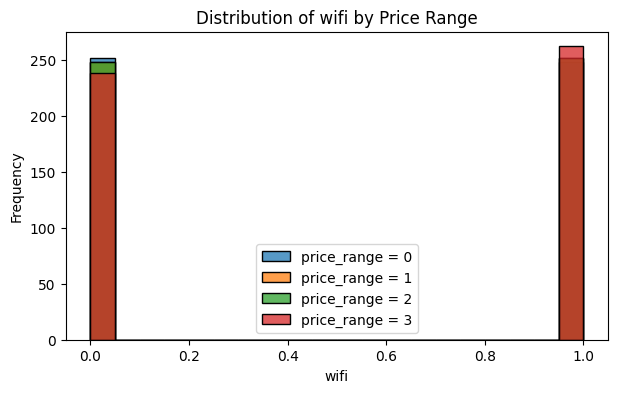

In [96]:
important_features = ['ram', 'battery_power', 'px_height', 'px_width']
very_low_features = ['three_g', 'touch_screen', 'four_g', 'wifi']

# Plot the histograms
for col in important_features + very_low_features:
    plt.figure(figsize=(7, 4))
    for cls in sorted(y.unique()):
        sns.histplot(X[col][y == cls], kde=False, label=f'price_range = {cls}', bins=20)
    plt.title(f'Distribution of {col} by Price Range')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [97]:
# Readjust the XGBoost model if you've lost it
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Collect valuables
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
})

# Sort from most to least important
importances = importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Qualitative method: classifying impact
def classificar_impacto(valor):
    if valor > 0.15:
        return 'Very High'
    elif valor > 0.10:
        return 'High'
    elif valor > 0.05:
        return 'Moderate'
    elif valor > 0.01:
        return 'Low'
    else:
        return 'Very Low'

importances['Impact'] = importances['Importance'].apply(classificar_impacto)

# Display final table
print(importances)

          Feature  Importance     Impact
0             ram    0.414434  Very High
1   battery_power    0.125947       High
2       px_height    0.079701   Moderate
3        px_width    0.075520   Moderate
4      int_memory    0.034347        Low
5           m_dep    0.031377        Low
6       mobile_wt    0.027997        Low
7        dual_sim    0.024962        Low
8            blue    0.024287        Low
9         n_cores    0.023033        Low
10             pc    0.020073        Low
11      talk_time    0.019378        Low
12    clock_speed    0.018595        Low
13           sc_h    0.015848        Low
14           sc_w    0.014910        Low
15           wifi    0.011530        Low
16             fc    0.010877        Low
17        three_g    0.009595   Very Low
18   touch_screen    0.009029   Very Low
19         four_g    0.008559   Very Low


c:\Users\lpraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:01:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.96      0.93      0.95       151
           1       0.87      0.94      0.90       146
           2       0.92      0.86      0.89       148
           3       0.93      0.95      0.94       155

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



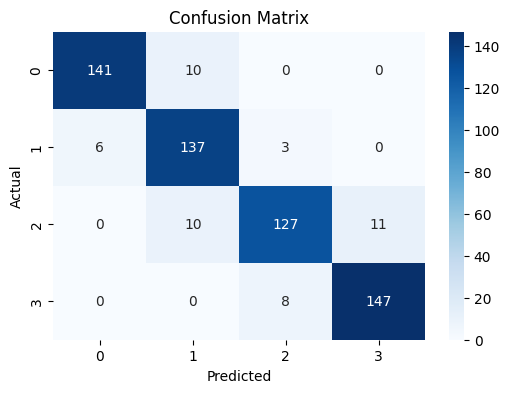

In [98]:
# Using only the 4 most important features
selected_features = ['ram', 'battery_power', 'px_height', 'px_width']
X_selected = df[selected_features]
y_target = df['price_range']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_target, test_size=0.3, random_state=42)

model_selected_features = XGBClassifier()
model_selected_features.fit(X_train, y_train)

# Evaluation
y_pred = model_selected_features.predict(X_test)
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

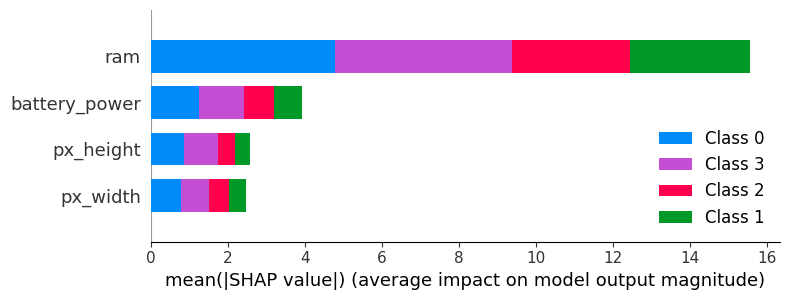

In [99]:
# Create explainer based on trained model
explainer = shap.Explainer(model_selected_features)

# Calculate the SHAP values for the test set
shap_values = explainer(X_test)

# Visualise the summary (importance and direction of impact)
shap.summary_plot(shap_values, X_test)

In [100]:
def predict_price_range(ram, battery_power, px_height, px_width):
    entrada = pd.DataFrame({
        'ram': [ram],
        'battery_power': [battery_power],
        'px_height': [px_height],
        'px_width': [px_width]
    })
    classe = model_selected_features.predict(entrada)[0]

    return classe


In [101]:
predict_price_range(4000, 15500, 200, 1200)

np.int64(3)

In [102]:

df_test = pd.read_csv('test.csv')


X_test_final = df_test[selected_features]


df_test['predicted_price_range'] = model_selected_features.predict(X_test_final)


print(df_test[['id', 'predicted_price_range']])
df_test.to_excel("test_results.xlsx", index=False)

       id  predicted_price_range
0       1                      3
1       2                      3
2       3                      2
3       4                      3
4       5                      1
5       6                      3
6       7                      3
7       8                      1
8       9                      3
9      10                      0
10     11                      3
11     12                      3
12     13                      0
13     14                      0
14     15                      2
15     16                      0
16     17                      2
17     18                      1
18     19                      3
19     20                      2
20     21                      1
21     22                      3
22     23                      1
23     24                      1
24     25                      3
25     26                      0
26     27                      2
27     28                      0
28     29                      3
29     30 

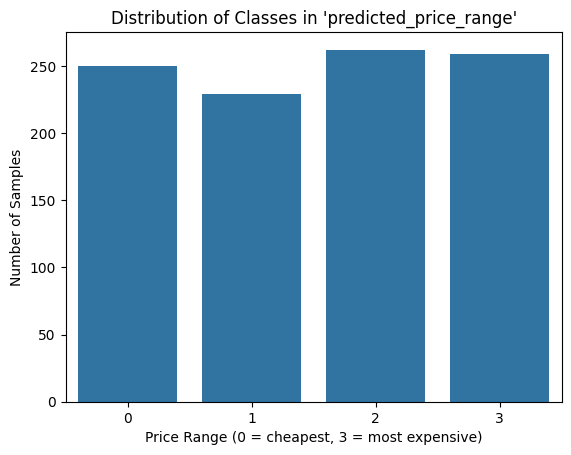

predicted_price_range
2    0.262
3    0.259
0    0.250
1    0.229
Name: Proportion, dtype: float64


In [103]:
df_test_results = pd.read_excel('test_results.xlsx')

X_test_results = df_test_results.drop('predicted_price_range', axis=1)
y_test_results = df_test_results['predicted_price_range']

sns.countplot(x=y_test_results)
plt.title("Distribution of Classes in 'predicted_price_range'")
plt.xlabel("Price Range (0 = cheapest, 3 = most expensive)")
plt.ylabel("Number of Samples")
plt.show()


print(y_test_results.value_counts(normalize=True).rename("Proportion"))